In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, roc_auc_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l1_l2
from tensorflow.keras.utils import to_categorical
from imblearn.over_sampling import SMOTE
import optuna

# Tải dữ liệu
input_path = '/kaggle/input'
train_file = os.path.join(input_path, 'child-mind-institute-problematic-internet-use/train.csv')
test_file = os.path.join(input_path, 'child-mind-institute-problematic-internet-use/test.csv')

train_df = pd.read_csv(train_file)
test_df = pd.read_csv(test_file)

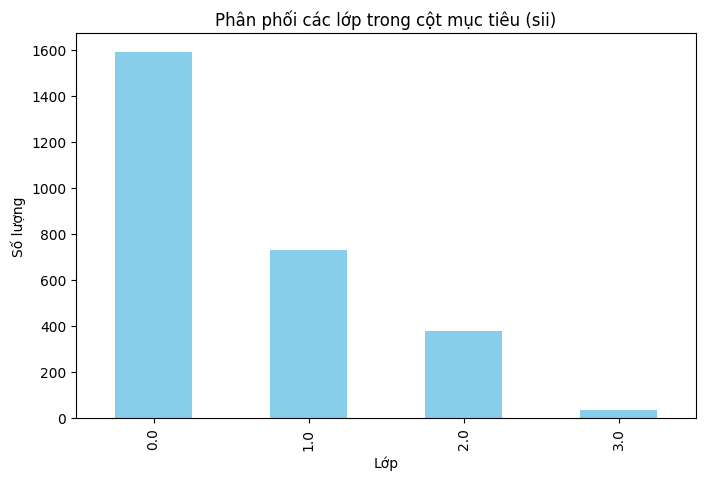

In [2]:
# Tách cột ID và cột mục tiêu
id_column = test_df['id']
test_df = test_df.drop(columns=['id'])
train_df = train_df.drop(columns=['id'])

# Xử lý cột mục tiêu
target = train_df.pop('sii')

# Loại bỏ các dòng có giá trị mục tiêu bị thiếu
train_df = train_df[target.notna()]
target = target[target.notna()]

# Biểu đồ kiểm tra cân bằng dữ liệu
plt.figure(figsize=(8, 5))
target.value_counts().plot(kind='bar', color='skyblue')
plt.title('Phân phối các lớp trong cột mục tiêu (sii)')
plt.xlabel('Lớp')
plt.ylabel('Số lượng')
plt.show()

In [3]:
# Mã hóa các biến phân loại
for col in train_df.columns:
    if train_df[col].dtype == 'object':
        train_df[col], _ = pd.factorize(train_df[col])
for col in test_df.columns:
    if test_df[col].dtype == 'object':
        test_df[col], _ = pd.factorize(test_df[col])

# Điền giá trị thiếu bằng trung vị
train_df.fillna(train_df.median(), inplace=True)
test_df.fillna(test_df.median(), inplace=True)

# Đồng bộ hóa các cột giữa dữ liệu huấn luyện và kiểm tra
common_columns = train_df.columns.intersection(test_df.columns)
train_df = train_df[common_columns]
test_df = test_df[common_columns]

# Chuẩn hóa dữ liệu
scaler = StandardScaler()
X = scaler.fit_transform(train_df)
X_test = scaler.transform(test_df)
y = target.values

# Cân bằng tập dữ liệu bằng SMOTE
smote = SMOTE(random_state=42, k_neighbors=5)
X, y = smote.fit_resample(X, y)

# Chuyển cột mục tiêu sang dạng one-hot encoding
y = to_categorical(y, num_classes=4)

# Chia dữ liệu huấn luyện và kiểm tra
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)


In [4]:
# Định nghĩa hàm mục tiêu cho Optuna
def objective(trial):
    model = Sequential()
    model.add(Dense(trial.suggest_int('units_layer1', 64, 256), activation='relu', input_shape=(X_train.shape[1],), kernel_regularizer=l1_l2(l1=1e-5, l2=1e-4)))
    model.add(BatchNormalization())
    model.add(Dropout(trial.suggest_float('dropout_layer1', 0.2, 0.5)))
    
    model.add(Dense(trial.suggest_int('units_layer2', 32, 128), activation='relu', kernel_regularizer=l1_l2(l1=1e-5, l2=1e-4)))
    model.add(BatchNormalization())
    model.add(Dropout(trial.suggest_float('dropout_layer2', 0.2, 0.5)))
    
    model.add(Dense(trial.suggest_int('units_layer3', 16, 64), activation='relu', kernel_regularizer=l1_l2(l1=1e-5, l2=1e-4)))
    model.add(BatchNormalization())
    model.add(Dropout(trial.suggest_float('dropout_layer3', 0.2, 0.5)))
    
    model.add(Dense(4, activation='softmax'))  # Lớp đầu ra cho bài toán phân loại đa lớp
    
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    
    model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100, batch_size=64, callbacks=[early_stopping], verbose=0)
    
    val_predictions = model.predict(X_val)
    val_auc = roc_auc_score(y_val, val_predictions, multi_class='ovr')
    
    return val_auc

# Tạo study và tối ưu hóa
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

print(f"Best trial: {study.best_trial.value}")
print(f"Best parameters: {study.best_trial.params}")

[I 2024-12-23 10:01:43,341] A new study created in memory with name: no-name-7d94004e-6d64-4551-86b1-eef0fcb8214a
/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


[I 2024-12-23 10:02:04,913] Trial 0 finished with value: 0.9448134005562523 and parameters: {'units_layer1': 143, 'dropout_layer1': 0.28208894785085903, 'units_layer2': 61, 'dropout_layer2': 0.2442062686545051, 'units_layer3': 58, 'dropout_layer3': 0.44952659905816994}. Best is trial 0 with value: 0.9448134005562523.
/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


[I 2024-12-23 10:02:32,595] Trial 1 finished with value: 0.9512055534895018 and parameters: {'units_layer1': 163, 'dropout_layer1': 0.3997951009797528, 'units_layer2': 64, 'dropout_layer2': 0.37582763903160854, 'units_layer3': 43, 'dropout_layer3': 0.25684950309032456}. Best is trial 1 with value: 0.9512055534895018.
/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


[I 2024-12-23 10:02:50,616] Trial 2 finished with value: 0.9504653422924378 and parameters: {'units_layer1': 135, 'dropout_layer1': 0.2178694101916883, 'units_layer2': 121, 'dropout_layer2': 0.25857849801185495, 'units_layer3': 22, 'dropout_layer3': 0.3648002085158537}. Best is trial 1 with value: 0.9512055534895018.
/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


[I 2024-12-23 10:03:18,461] Trial 3 finished with value: 0.9460698658300761 and parameters: {'units_layer1': 122, 'dropout_layer1': 0.2992495572940874, 'units_layer2': 84, 'dropout_layer2': 0.4829479100407046, 'units_layer3': 44, 'dropout_layer3': 0.41631687572782183}. Best is trial 1 with value: 0.9512055534895018.
/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


[I 2024-12-23 10:03:31,579] Trial 4 finished with value: 0.9059004911468352 and parameters: {'units_layer1': 73, 'dropout_layer1': 0.2913449943814734, 'units_layer2': 53, 'dropout_layer2': 0.4410182676165263, 'units_layer3': 51, 'dropout_layer3': 0.25563308356783554}. Best is trial 1 with value: 0.9512055534895018.
/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


[I 2024-12-23 10:03:53,694] Trial 5 finished with value: 0.9458063044739959 and parameters: {'units_layer1': 179, 'dropout_layer1': 0.37992525568567803, 'units_layer2': 64, 'dropout_layer2': 0.26889323081603533, 'units_layer3': 52, 'dropout_layer3': 0.25007039767778744}. Best is trial 1 with value: 0.9512055534895018.
/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


[I 2024-12-23 10:04:16,743] Trial 6 finished with value: 0.9471592531115811 and parameters: {'units_layer1': 177, 'dropout_layer1': 0.2151964147129533, 'units_layer2': 49, 'dropout_layer2': 0.3738223634728952, 'units_layer3': 23, 'dropout_layer3': 0.3019599075125118}. Best is trial 1 with value: 0.9512055534895018.
/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


[I 2024-12-23 10:04:35,787] Trial 7 finished with value: 0.9474069621497991 and parameters: {'units_layer1': 175, 'dropout_layer1': 0.268025347254848, 'units_layer2': 63, 'dropout_layer2': 0.27769553008507825, 'units_layer3': 60, 'dropout_layer3': 0.32963208280000855}. Best is trial 1 with value: 0.9512055534895018.
/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


[I 2024-12-23 10:04:56,697] Trial 8 finished with value: 0.9372819090367381 and parameters: {'units_layer1': 94, 'dropout_layer1': 0.22778845978883996, 'units_layer2': 91, 'dropout_layer2': 0.4881904388399286, 'units_layer3': 35, 'dropout_layer3': 0.26777726523409223}. Best is trial 1 with value: 0.9512055534895018.
/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


[I 2024-12-23 10:05:20,378] Trial 9 finished with value: 0.9476114649731885 and parameters: {'units_layer1': 231, 'dropout_layer1': 0.21550222304650057, 'units_layer2': 37, 'dropout_layer2': 0.465815652340955, 'units_layer3': 48, 'dropout_layer3': 0.38518781776456457}. Best is trial 1 with value: 0.9512055534895018.
/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


[I 2024-12-23 10:05:49,118] Trial 10 finished with value: 0.9530333191562178 and parameters: {'units_layer1': 236, 'dropout_layer1': 0.47439234797983726, 'units_layer2': 106, 'dropout_layer2': 0.3634176955707107, 'units_layer3': 36, 'dropout_layer3': 0.2199852270140346}. Best is trial 10 with value: 0.9530333191562178.
/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


[I 2024-12-23 10:06:13,082] Trial 11 finished with value: 0.9497402031380271 and parameters: {'units_layer1': 251, 'dropout_layer1': 0.4749717591173499, 'units_layer2': 108, 'dropout_layer2': 0.3600789438213635, 'units_layer3': 35, 'dropout_layer3': 0.20056488281390977}. Best is trial 10 with value: 0.9530333191562178.
/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


[I 2024-12-23 10:06:37,643] Trial 12 finished with value: 0.9438328667332276 and parameters: {'units_layer1': 217, 'dropout_layer1': 0.4789321776930272, 'units_layer2': 100, 'dropout_layer2': 0.4067550423334947, 'units_layer3': 36, 'dropout_layer3': 0.20622394146239875}. Best is trial 10 with value: 0.9530333191562178.
/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


[I 2024-12-23 10:07:03,784] Trial 13 finished with value: 0.9534911424727053 and parameters: {'units_layer1': 207, 'dropout_layer1': 0.40672725131758397, 'units_layer2': 126, 'dropout_layer2': 0.3181365662935381, 'units_layer3': 29, 'dropout_layer3': 0.2873017388858619}. Best is trial 13 with value: 0.9534911424727053.
/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


[I 2024-12-23 10:07:24,458] Trial 14 finished with value: 0.9459761866942378 and parameters: {'units_layer1': 208, 'dropout_layer1': 0.4287699222854479, 'units_layer2': 121, 'dropout_layer2': 0.31268528015455205, 'units_layer3': 28, 'dropout_layer3': 0.29984990528431116}. Best is trial 13 with value: 0.9534911424727053.
/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


[I 2024-12-23 10:07:44,066] Trial 15 finished with value: 0.9415375445394569 and parameters: {'units_layer1': 255, 'dropout_layer1': 0.43449398695383457, 'units_layer2': 128, 'dropout_layer2': 0.20092227381412528, 'units_layer3': 17, 'dropout_layer3': 0.49376522690158076}. Best is trial 13 with value: 0.9534911424727053.
/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


[I 2024-12-23 10:08:08,078] Trial 16 finished with value: 0.9513317647949082 and parameters: {'units_layer1': 202, 'dropout_layer1': 0.34064009360191555, 'units_layer2': 108, 'dropout_layer2': 0.33111497548634505, 'units_layer3': 28, 'dropout_layer3': 0.31104659356811304}. Best is trial 13 with value: 0.9534911424727053.
/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


[I 2024-12-23 10:08:29,664] Trial 17 finished with value: 0.9404217081573829 and parameters: {'units_layer1': 233, 'dropout_layer1': 0.49447741627080616, 'units_layer2': 110, 'dropout_layer2': 0.31015094364791473, 'units_layer3': 31, 'dropout_layer3': 0.22821113474079352}. Best is trial 13 with value: 0.9534911424727053.
/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


[I 2024-12-23 10:08:56,141] Trial 18 finished with value: 0.9461909134573396 and parameters: {'units_layer1': 195, 'dropout_layer1': 0.44662593693828306, 'units_layer2': 91, 'dropout_layer2': 0.4276931984101845, 'units_layer3': 41, 'dropout_layer3': 0.2834971062144993}. Best is trial 13 with value: 0.9534911424727053.
/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


[I 2024-12-23 10:09:21,806] Trial 19 finished with value: 0.9525825744683055 and parameters: {'units_layer1': 232, 'dropout_layer1': 0.35379355124708245, 'units_layer2': 117, 'dropout_layer2': 0.40129704853881304, 'units_layer3': 22, 'dropout_layer3': 0.231466311032113}. Best is trial 13 with value: 0.9534911424727053.
/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


[I 2024-12-23 10:09:43,302] Trial 20 finished with value: 0.9402012519470422 and parameters: {'units_layer1': 192, 'dropout_layer1': 0.39956798749697664, 'units_layer2': 99, 'dropout_layer2': 0.33578482593058806, 'units_layer3': 16, 'dropout_layer3': 0.3410189157746285}. Best is trial 13 with value: 0.9534911424727053.
/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


[I 2024-12-23 10:10:03,712] Trial 21 finished with value: 0.9498152113885043 and parameters: {'units_layer1': 223, 'dropout_layer1': 0.3425974745658753, 'units_layer2': 128, 'dropout_layer2': 0.3944024595821115, 'units_layer3': 23, 'dropout_layer3': 0.2257640677966371}. Best is trial 13 with value: 0.9534911424727053.
/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


[I 2024-12-23 10:10:28,835] Trial 22 finished with value: 0.9521511039661199 and parameters: {'units_layer1': 239, 'dropout_layer1': 0.3719070380878578, 'units_layer2': 119, 'dropout_layer2': 0.40329458942760166, 'units_layer3': 30, 'dropout_layer3': 0.22878778148686513}. Best is trial 13 with value: 0.9534911424727053.
/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


[I 2024-12-23 10:10:52,881] Trial 23 finished with value: 0.9561889526808868 and parameters: {'units_layer1': 244, 'dropout_layer1': 0.32182669481017784, 'units_layer2': 114, 'dropout_layer2': 0.30322722507991995, 'units_layer3': 20, 'dropout_layer3': 0.2794641722359693}. Best is trial 23 with value: 0.9561889526808868.
/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


[I 2024-12-23 10:11:18,635] Trial 24 finished with value: 0.9488855235167586 and parameters: {'units_layer1': 244, 'dropout_layer1': 0.4564848554719924, 'units_layer2': 78, 'dropout_layer2': 0.29123512479107966, 'units_layer3': 26, 'dropout_layer3': 0.2812015276290436}. Best is trial 23 with value: 0.9561889526808868.
/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


[I 2024-12-23 10:11:42,253] Trial 25 finished with value: 0.9590542585819345 and parameters: {'units_layer1': 215, 'dropout_layer1': 0.31918802696381093, 'units_layer2': 113, 'dropout_layer2': 0.23456367309382886, 'units_layer3': 33, 'dropout_layer3': 0.3248957492164867}. Best is trial 25 with value: 0.9590542585819345.
/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


[I 2024-12-23 10:12:01,114] Trial 26 finished with value: 0.9494438375053289 and parameters: {'units_layer1': 212, 'dropout_layer1': 0.31614170670542313, 'units_layer2': 114, 'dropout_layer2': 0.23046598152768127, 'units_layer3': 33, 'dropout_layer3': 0.36757706290784686}. Best is trial 25 with value: 0.9590542585819345.
/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


[I 2024-12-23 10:12:19,486] Trial 27 finished with value: 0.9513967868946924 and parameters: {'units_layer1': 189, 'dropout_layer1': 0.25476266700194355, 'units_layer2': 100, 'dropout_layer2': 0.21214934749270795, 'units_layer3': 19, 'dropout_layer3': 0.3222027112544634}. Best is trial 25 with value: 0.9590542585819345.
/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


[I 2024-12-23 10:12:35,190] Trial 28 finished with value: 0.9401960456227084 and parameters: {'units_layer1': 216, 'dropout_layer1': 0.3185588665245838, 'units_layer2': 128, 'dropout_layer2': 0.29236919337315576, 'units_layer3': 25, 'dropout_layer3': 0.39420629649865463}. Best is trial 25 with value: 0.9590542585819345.
/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


[I 2024-12-23 10:12:54,634] Trial 29 finished with value: 0.9525487170228979 and parameters: {'units_layer1': 255, 'dropout_layer1': 0.3180668999674119, 'units_layer2': 75, 'dropout_layer2': 0.24461514735650652, 'units_layer3': 64, 'dropout_layer3': 0.35027418553134093}. Best is trial 25 with value: 0.9590542585819345.
/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


[I 2024-12-23 10:13:12,496] Trial 30 finished with value: 0.941031238196244 and parameters: {'units_layer1': 152, 'dropout_layer1': 0.40873858675189123, 'units_layer2': 92, 'dropout_layer2': 0.24601313978180506, 'units_layer3': 39, 'dropout_layer3': 0.28295650195687044}. Best is trial 25 with value: 0.9590542585819345.
/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


[I 2024-12-23 10:13:32,871] Trial 31 finished with value: 0.9467516026926441 and parameters: {'units_layer1': 226, 'dropout_layer1': 0.36605171258271363, 'units_layer2': 111, 'dropout_layer2': 0.345526163628462, 'units_layer3': 38, 'dropout_layer3': 0.2987604000961099}. Best is trial 25 with value: 0.9590542585819345.
/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


[I 2024-12-23 10:13:56,486] Trial 32 finished with value: 0.9506345047424085 and parameters: {'units_layer1': 242, 'dropout_layer1': 0.415081712161184, 'units_layer2': 104, 'dropout_layer2': 0.3178888572105608, 'units_layer3': 31, 'dropout_layer3': 0.26845297007061786}. Best is trial 25 with value: 0.9590542585819345.
/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


[I 2024-12-23 10:14:14,464] Trial 33 finished with value: 0.946976433044612 and parameters: {'units_layer1': 203, 'dropout_layer1': 0.38299576409901154, 'units_layer2': 121, 'dropout_layer2': 0.3018274501407652, 'units_layer3': 42, 'dropout_layer3': 0.2474542065044669}. Best is trial 25 with value: 0.9590542585819345.
/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


[I 2024-12-23 10:14:36,141] Trial 34 finished with value: 0.9454757563258778 and parameters: {'units_layer1': 161, 'dropout_layer1': 0.33233198870238917, 'units_layer2': 114, 'dropout_layer2': 0.37346639674090537, 'units_layer3': 45, 'dropout_layer3': 0.31907700944430295}. Best is trial 25 with value: 0.9590542585819345.
/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


[I 2024-12-23 10:15:00,536] Trial 35 finished with value: 0.9556020072672137 and parameters: {'units_layer1': 219, 'dropout_layer1': 0.28646795712309486, 'units_layer2': 122, 'dropout_layer2': 0.2673293552998691, 'units_layer3': 20, 'dropout_layer3': 0.43998477980421075}. Best is trial 25 with value: 0.9590542585819345.
/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


[I 2024-12-23 10:15:24,568] Trial 36 finished with value: 0.9450571216829651 and parameters: {'units_layer1': 133, 'dropout_layer1': 0.27629478531928, 'units_layer2': 122, 'dropout_layer2': 0.2652836666191173, 'units_layer3': 18, 'dropout_layer3': 0.4219251722118865}. Best is trial 25 with value: 0.9590542585819345.
/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


[I 2024-12-23 10:15:42,387] Trial 37 finished with value: 0.9428553911413506 and parameters: {'units_layer1': 184, 'dropout_layer1': 0.2985243901261061, 'units_layer2': 123, 'dropout_layer2': 0.22683486038022396, 'units_layer3': 20, 'dropout_layer3': 0.4802191354219252}. Best is trial 25 with value: 0.9590542585819345.
/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


[I 2024-12-23 10:15:59,985] Trial 38 finished with value: 0.9449176462345756 and parameters: {'units_layer1': 170, 'dropout_layer1': 0.24933434536736138, 'units_layer2': 116, 'dropout_layer2': 0.27646244075721016, 'units_layer3': 26, 'dropout_layer3': 0.4487255913995327}. Best is trial 25 with value: 0.9590542585819345.
/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


[I 2024-12-23 10:16:23,918] Trial 39 finished with value: 0.9461391991313113 and parameters: {'units_layer1': 106, 'dropout_layer1': 0.28138225259212146, 'units_layer2': 85, 'dropout_layer2': 0.25573789265502656, 'units_layer3': 21, 'dropout_layer3': 0.3566427275291314}. Best is trial 25 with value: 0.9590542585819345.
/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


[I 2024-12-23 10:16:45,662] Trial 40 finished with value: 0.9428086224517133 and parameters: {'units_layer1': 64, 'dropout_layer1': 0.23715425204885648, 'units_layer2': 96, 'dropout_layer2': 0.2254994018977624, 'units_layer3': 25, 'dropout_layer3': 0.33469731117482915}. Best is trial 25 with value: 0.9590542585819345.
/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


[I 2024-12-23 10:17:07,594] Trial 41 finished with value: 0.954701801022565 and parameters: {'units_layer1': 219, 'dropout_layer1': 0.3089605619766435, 'units_layer2': 105, 'dropout_layer2': 0.2884380713549363, 'units_layer3': 33, 'dropout_layer3': 0.266299530475268}. Best is trial 25 with value: 0.9590542585819345.
/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


[I 2024-12-23 10:17:23,432] Trial 42 finished with value: 0.944871200916736 and parameters: {'units_layer1': 221, 'dropout_layer1': 0.3012927673113928, 'units_layer2': 124, 'dropout_layer2': 0.2915745038452285, 'units_layer3': 33, 'dropout_layer3': 0.2673720184874287}. Best is trial 25 with value: 0.9590542585819345.
/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


[I 2024-12-23 10:17:43,664] Trial 43 finished with value: 0.9495695316305865 and parameters: {'units_layer1': 199, 'dropout_layer1': 0.32979498201611196, 'units_layer2': 113, 'dropout_layer2': 0.28002636727511454, 'units_layer3': 28, 'dropout_layer3': 0.24876916100232593}. Best is trial 25 with value: 0.9590542585819345.
/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


[I 2024-12-23 10:18:04,951] Trial 44 finished with value: 0.9498802786618286 and parameters: {'units_layer1': 208, 'dropout_layer1': 0.3556812050537652, 'units_layer2': 104, 'dropout_layer2': 0.3284887780545824, 'units_layer3': 33, 'dropout_layer3': 0.29605528733977987}. Best is trial 25 with value: 0.9590542585819345.
/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


[I 2024-12-23 10:18:26,374] Trial 45 finished with value: 0.9556872236240285 and parameters: {'units_layer1': 245, 'dropout_layer1': 0.2914455625085592, 'units_layer2': 117, 'dropout_layer2': 0.2574368936922727, 'units_layer3': 24, 'dropout_layer3': 0.3722546157126235}. Best is trial 25 with value: 0.9590542585819345.
/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


[I 2024-12-23 10:18:45,285] Trial 46 finished with value: 0.9423691013388431 and parameters: {'units_layer1': 247, 'dropout_layer1': 0.2613665399771418, 'units_layer2': 117, 'dropout_layer2': 0.2589162470984955, 'units_layer3': 22, 'dropout_layer3': 0.43019826433867386}. Best is trial 25 with value: 0.9590542585819345.
/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


[I 2024-12-23 10:19:06,548] Trial 47 finished with value: 0.9524486602934988 and parameters: {'units_layer1': 227, 'dropout_layer1': 0.30448008485254946, 'units_layer2': 104, 'dropout_layer2': 0.2347974534184363, 'units_layer3': 54, 'dropout_layer3': 0.39992575544234865}. Best is trial 25 with value: 0.9590542585819345.
/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


[I 2024-12-23 10:19:27,094] Trial 48 finished with value: 0.9503015385962346 and parameters: {'units_layer1': 239, 'dropout_layer1': 0.2901769062251215, 'units_layer2': 70, 'dropout_layer2': 0.2730086742664309, 'units_layer3': 16, 'dropout_layer3': 0.36715803009056147}. Best is trial 25 with value: 0.9590542585819345.
/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


[I 2024-12-23 10:19:49,249] Trial 49 finished with value: 0.9546886778209951 and parameters: {'units_layer1': 249, 'dropout_layer1': 0.27203946683292984, 'units_layer2': 84, 'dropout_layer2': 0.2126963138464851, 'units_layer3': 24, 'dropout_layer3': 0.455628845496979}. Best is trial 25 with value: 0.9590542585819345.


Best trial: 0.9590542585819345
Best parameters: {'units_layer1': 215, 'dropout_layer1': 0.31918802696381093, 'units_layer2': 113, 'dropout_layer2': 0.23456367309382886, 'units_layer3': 33, 'dropout_layer3': 0.3248957492164867}


In [5]:
# Sử dụng các tham số tốt nhất để huấn luyện mô hình cuối cùng
best_params = study.best_trial.params

model = Sequential()
model.add(Dense(best_params['units_layer1'], activation='relu', input_shape=(X_train.shape[1],), kernel_regularizer=l1_l2(l1=1e-5, l2=1e-4)))
model.add(BatchNormalization())
model.add(Dropout(best_params['dropout_layer1']))

model.add(Dense(best_params['units_layer2'], activation='relu', kernel_regularizer=l1_l2(l1=1e-5, l2=1e-4)))
model.add(BatchNormalization())
model.add(Dropout(best_params['dropout_layer2']))

model.add(Dense(best_params['units_layer3'], activation='relu', kernel_regularizer=l1_l2(l1=1e-5, l2=1e-4)))
model.add(BatchNormalization())
model.add(Dropout(best_params['dropout_layer3']))

model.add(Dense(4, activation='softmax'))  # Lớp đầu ra cho bài toán phân loại đa lớp

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100, batch_size=64, callbacks=[early_stopping], verbose=2)


/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
80/80 - 4s - 44ms/step - accuracy: 0.4520 - loss: 1.4687 - val_accuracy: 0.5862 - val_loss: 1.0732
Epoch 2/100
80/80 - 0s - 5ms/step - accuracy: 0.5688 - loss: 1.1026 - val_accuracy: 0.6654 - val_loss: 0.9027
Epoch 3/100
80/80 - 0s - 5ms/step - accuracy: 0.6129 - loss: 0.9718 - val_accuracy: 0.6975 - val_loss: 0.8080
Epoch 4/100
80/80 - 0s - 5ms/step - accuracy: 0.6357 - loss: 0.8982 - val_accuracy: 0.7155 - val_loss: 0.7566
Epoch 5/100
80/80 - 0s - 5ms/step - accuracy: 0.6690 - loss: 0.8290 - val_accuracy: 0.7210 - val_loss: 0.7230
Epoch 6/100
80/80 - 0s - 5ms/step - accuracy: 0.6876 - loss: 0.7843 - val_accuracy: 0.7265 - val_loss: 0.6957
Epoch 7/100
80/80 - 0s - 5ms/step - accuracy: 0.7045 - loss: 0.7568 - val_accuracy: 0.7328 - val_loss: 0.6799
Epoch 8/100
80/80 - 0s - 5ms/step - accuracy: 0.7112 - loss: 0.7246 - val_accuracy: 0.7484 - val_loss: 0.6635
Epoch 9/100
80/80 - 0s - 5ms/step - accuracy: 0.7186 - loss: 0.7123 - val_accuracy: 0.7414 - val_loss: 0.6531
Epoch 10/

In [6]:
# Đánh giá trên tập kiểm tra
val_predictions = model.predict(X_val)
val_auc = roc_auc_score(y_val, val_predictions, multi_class='ovr')
print(f"Validation AUC: {val_auc:.4f}")

val_labels = np.argmax(y_val, axis=1)
pred_labels = np.argmax(val_predictions, axis=1)
val_accuracy = np.mean(val_labels == pred_labels)
print(f"Validation Accuracy: {val_accuracy:.4f}")

# Huấn luyện lại trên toàn bộ dữ liệu
model.fit(X, y, epochs=100, batch_size=64, callbacks=[early_stopping], verbose=2)


40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Validation AUC: 0.9497
Validation Accuracy: 0.8088
Epoch 1/100
100/100 - 0s - 4ms/step - accuracy: 0.8327 - loss: 0.4858
Epoch 2/100


/opt/conda/lib/python3.10/site-packages/keras/src/callbacks/early_stopping.py:155: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: accuracy,loss
  current = self.get_monitor_value(logs)


100/100 - 0s - 5ms/step - accuracy: 0.8386 - loss: 0.4719
Epoch 3/100
100/100 - 0s - 5ms/step - accuracy: 0.8356 - loss: 0.4592
Epoch 4/100
100/100 - 0s - 5ms/step - accuracy: 0.8408 - loss: 0.4555
Epoch 5/100
100/100 - 0s - 5ms/step - accuracy: 0.8483 - loss: 0.4305
Epoch 6/100
100/100 - 0s - 5ms/step - accuracy: 0.8446 - loss: 0.4438
Epoch 7/100
100/100 - 0s - 5ms/step - accuracy: 0.8438 - loss: 0.4374
Epoch 8/100
100/100 - 0s - 5ms/step - accuracy: 0.8532 - loss: 0.4229
Epoch 9/100
100/100 - 0s - 5ms/step - accuracy: 0.8566 - loss: 0.4084
Epoch 10/100
100/100 - 0s - 5ms/step - accuracy: 0.8585 - loss: 0.4094
Epoch 11/100
100/100 - 0s - 5ms/step - accuracy: 0.8637 - loss: 0.3995
Epoch 12/100
100/100 - 0s - 5ms/step - accuracy: 0.8617 - loss: 0.4048
Epoch 13/100
100/100 - 0s - 5ms/step - accuracy: 0.8646 - loss: 0.3995
Epoch 14/100
100/100 - 0s - 5ms/step - accuracy: 0.8621 - loss: 0.3963
Epoch 15/100
100/100 - 0s - 5ms/step - accuracy: 0.8667 - loss: 0.4049
Epoch 16/100
100/100 - 0s 

In [7]:
# Dự đoán trên tập kiểm tra
test_predictions = model.predict(X_test)
test_labels = np.argmax(test_predictions, axis=1)

# Chuẩn bị tệp nộp
submission = pd.DataFrame({'id': id_column, 'sii': test_labels})
submission.to_csv('/kaggle/working/submission.csv', index=False)
print("Tệp nộp đã được lưu: /kaggle/working/submission.csv")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Tệp nộp đã được lưu: /kaggle/working/submission.csv
